# Inspect jump around 5800 A


In this notebook, I investigate several metrics to quantify issues in flux calibration that cause a jump in the continuum around 5800 A.


The relevant metrics collected using the script [collect_fiber_metrics.py](https://github.com/sdss/lvmsky/blob/main/notebooks/collect_fiber_metrics.py) and contained metrics defined as follows:

```
dict(name='cont5800_full', wave=5800, cont_regions=[[-10, 10]]),
dict(name='cont5800_left', wave=5800-10, cont_regions=[[-10, 7]]),
dict(name='cont5800_right', wave=5800+10, cont_regions=[[-7, 10]]),
```

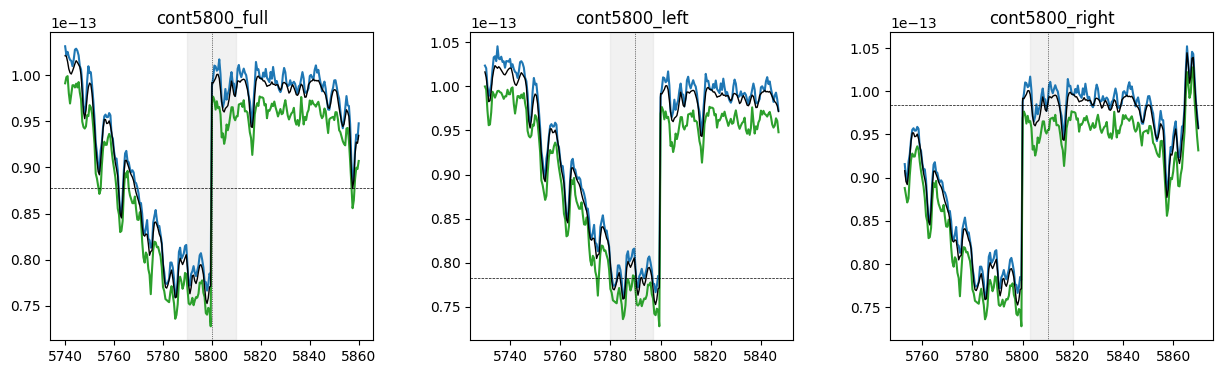


The full table with these and other metrics are in the file [lvm_per_fiber_sky_metrics_1.1.0.fits (6.3Gb)](https://data.sdss5.org/sas/sdsswork/lvm/sandbox/lvmsky_inspect/lvm_per_fiber_sky_metrics_1.1.0.fits).


Relevant list of columns in this table:
Exposure and fiber identifiers:
- exposure
- mjd
- tile_id
- dpos
- fiberid
- spectrographid
- blockid
- finblock
- targettype
- ifulabel
- finifu
- telescope
- fibstatus
- ra
- dec

5800 jump related:

- s_cont5800_full_median
- s_cont5800_full_mean
- s_cont5800_full_std
- c_cont5800_full_median
- c_cont5800_full_mean
- c_cont5800_full_std
- s_cont5800_left_median
- s_cont5800_left_mean
- s_cont5800_left_std
- c_cont5800_left_median
- c_cont5800_left_mean
- c_cont5800_left_std
- s_cont5800_right_median
- s_cont5800_right_mean
- s_cont5800_right_std
- c_cont5800_right_median
- c_cont5800_right_mean
- c_cont5800_right_std


`s_`, `c_` correspond to values retrieved from `FLUX` extension or `FLUX` + `SKY` from SFrames RSSfile. `full`, `left`, `right` define the spectral fragment. And `mean`, `median`, `std` - different averaging functions applied to small spectral fragments.

In [20]:
import os
from astropy.io import fits
from astropy.table import Table, join, hstack
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

In [3]:
t = Table.read("lvm_per_fiber_sky_metrics_1.1.0.fits")
t

exposure,mjd,tile_id,dpos,fiberid,spectrographid,blockid,finblock,targettype,ifulabel,finifu,telescope,fibstatus,ra,dec,s_OI_5577_sum,s_OI_5577_sumtrapz,s_OI_5577_mean,s_OI_5577_std,s_OI_5577_cont_median,s_OI_5577_cont_mean,c_OI_5577_sum,c_OI_5577_sumtrapz,c_OI_5577_mean,c_OI_5577_std,c_OI_5577_cont_median,c_OI_5577_cont_mean,s_Na_5893_sum,s_Na_5893_sumtrapz,s_Na_5893_mean,s_Na_5893_std,s_Na_5893_cont_median,s_Na_5893_cont_mean,c_Na_5893_sum,c_Na_5893_sumtrapz,c_Na_5893_mean,c_Na_5893_std,c_Na_5893_cont_median,c_Na_5893_cont_mean,s_OI_6300_sum,s_OI_6300_sumtrapz,s_OI_6300_mean,s_OI_6300_std,s_OI_6300_cont_median,s_OI_6300_cont_mean,c_OI_6300_sum,c_OI_6300_sumtrapz,c_OI_6300_mean,c_OI_6300_std,c_OI_6300_cont_median,c_OI_6300_cont_mean,s_OH_7341_sum,s_OH_7341_sumtrapz,s_OH_7341_mean,s_OH_7341_std,s_OH_7341_cont_median,s_OH_7341_cont_mean,c_OH_7341_sum,c_OH_7341_sumtrapz,c_OH_7341_mean,c_OH_7341_std,c_OH_7341_cont_median,c_OH_7341_cont_mean,s_O2_8650_sum,s_O2_8650_sumtrapz,s_O2_8650_mean,s_O2_8650_std,s_O2_8650_cont_median,s_O2_8650_cont_mean,c_O2_8650_sum,c_O2_8650_sumtrapz,c_O2_8650_mean,c_O2_8650_std,c_O2_8650_cont_median,c_O2_8650_cont_mean,s_Bcont_median,s_Bcont_mean,s_Bcont_std,c_Bcont_median,c_Bcont_mean,c_Bcont_std,s_Rcont_median,s_Rcont_mean,s_Rcont_std,c_Rcont_median,c_Rcont_mean,c_Rcont_std,s_Zcont_median,s_Zcont_mean,s_Zcont_std,c_Zcont_median,c_Zcont_mean,c_Zcont_std,s_cont5800_full_median,s_cont5800_full_mean,s_cont5800_full_std,c_cont5800_full_median,c_cont5800_full_mean,c_cont5800_full_std,s_cont5800_left_median,s_cont5800_left_mean,s_cont5800_left_std,c_cont5800_left_median,c_cont5800_left_mean,c_cont5800_left_std,s_cont5800_right_median,s_cont5800_right_mean,s_cont5800_right_std,c_cont5800_right_median,c_cont5800_right_mean,c_cont5800_right_std
int64,int64,int64,int64,int64,int64,bytes3,int64,bytes8,bytes5,int64,bytes4,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
7325,60255,1029275,0,1,1,B1,1,SKY,SkyW3,1,SkyW,0,76.69255714129727,-3.3429802859360365,9.000425e-14,9.094690142282533e-14,1.5000708e-14,6.3205876e-14,-8.5490704e-17,-1.627679e-16,1.7712719e-12,1.7705318520554978e-12,2.95212e-13,4.2329397e-13,1.1071844e-14,1.1076586e-14,6.2285016e-14,6.256014804622905e-14,4.613705e-15,7.296207e-15,-2.0663117e-16,1.3655528e-17,3.2976887e-13,3.2987727395807054e-13,2.4427324e-14,3.144896e-14,1.1118846e-14,1.1486393e-14,7.2204903e-14,7.143671972489563e-14,1.203415e-14,1.8855057e-14,-1.4769684e-16,-2.9100894e-16,3.4230813e-13,3.3884316407981117e-13,5.7051355e-14,7.6071446e-14,9.528711e-15,9.467824e-15,2.8769643e-14,2.8982238618386783e-14,4.7949404e-15,1.1346808e-14,5.4511144e-16,5.9180604e-16,3.0162163e-13,3.020701201769427e-13,5.027027e-14,7.521521e-14,8.957398e-15,9.0747264e-15,2.8556202e-13,2.8564731533162237e-13,2.732651e-15,4.4151957e-15,4.4403548e-16,3.8680363e-16,2.341269e-12,2.340893539944504e-12,2.2404489e-14,2.0842028e-14,7.558401e-15,7.487518e-15,2.4179482e-17,4.197398e-17,1.3100655e-15,1.03298345e-14,1.0321507e-14,1.2813747e-15,-7.521691e-17,-1.963703e-17,7.382656e-16,7.667381e-15,7.712306e-15,7.8360034e-16,6.917191e-16,6.450906e-16,5.4130943e-16,6.788759e-15,6.7723295e-15,6.171249e-16,-3.219876e-16,4.807166e-16,2.896924e-15,8.570727e-15,1.03210024e-14,3.894148e-15,-2.440448e-16,-3.7

# From fiber to exposure metrics


First, select fibers for Science exposures and good fibers.

In [9]:
mask_good_science = (t['telescope'] == b'Sci ') & (t['fibstatus'] == 0)

ts = t[mask_good_science]

print("Number of all fibers: ", len(t))
print("Number of good science fibers: ", len(ts))

Number of all fibers:  11908944
Number of good science fibers:  10745004


Add `jump_ratio` column

In [13]:
ts['jump5800_ratio'] = ts['c_cont5800_right_median'] / ts['c_cont5800_left_median']

Now group by `expnum` to calculate exposure-wise metrics.

In [14]:
ts_by_exposure = ts.group_by('exposure')

Check the number of groups to ensure it matches the number exposures available in version 1.1.0.

In [15]:
print(len(ts_by_exposure.groups.keys))

6126


Now aggregate metrics

In [26]:
agr_median = ts_by_exposure['exposure', 'jump5800_ratio', 'c_cont5800_full_std', 'c_cont5800_right_median'].groups.aggregate(np.nanmedian)
agr_median.rename_column('jump5800_ratio', 'median_jump5800_ratio')
agr_median.rename_column('c_cont5800_full_std', 'median_c_cont5800_full_std')
agr_median.rename_column('c_cont5800_right_median', 'median_c_cont5800_right_median')

agr_std = ts_by_exposure['exposure', 'c_cont5800_right_median'].groups.aggregate(np.nanstd)
agr_std.rename_column('c_cont5800_right_median', 'std_c_cont5800_right_median')

exposures = join(agr_median, agr_std, keys='exposure')


exposures.write("exposures_jump5800.fits", overwrite=True)

exposures

exposure,median_jump5800_ratio,median_c_cont5800_full_std,median_c_cont5800_right_median,std_c_cont5800_right_median
int64,float64,float64,float64,float32
7325,1.3372806310653687,1.803664334586782e-15,8.249691789343361e-15,4.100846e-14
7326,1.2935632467269897,1.7508696180173686e-15,8.563352324876365e-15,1.3235482e-13
7327,1.3306334018707275,1.784877567333155e-15,8.471140930106473e-15,5.5898774e-14
7328,1.3083341121673584,1.7320288524133544e-15,8.553647021366725e-15,4.1593316e-14
7329,1.296748161315918,1.6729136818706479e-15,7.616972577304502e-15,1.265997e-14
7330,1.3454543352127075,1.6150078626183837e-15,7.249134120399219e-15,4.7488223e-13
7331,1.2875579595565796,1.6548822562477352e-15,7.448189404102822e-15,1.3248509e-12
7332,1.285517930984497,1.5686688076564691e-15,7.289248753748236e-15,5.459438e-14
7333,1.2934728860855103,1.8092225647866646e-15,8.754461592501775e-15,4.970553e-12


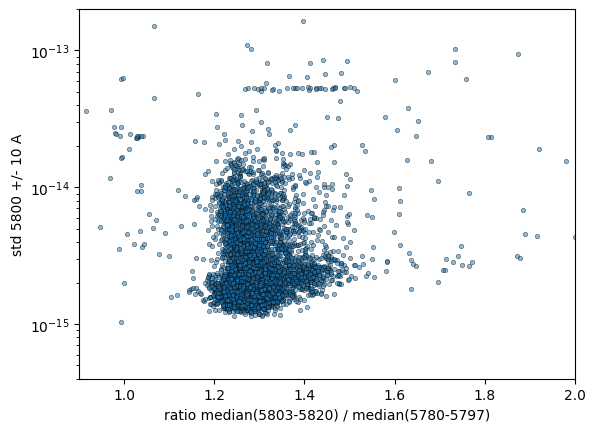

In [56]:
plt.scatter(exposures['median_jump5800_ratio'], exposures['median_c_cont5800_full_std'], marker='o', s=10, edgecolor='k', linewidth=0.5, alpha=0.5)
plt.xlim(0.9, 2)
plt.ylim(4e-16, 2e-13)
plt.xlabel('ratio median(5803-5820) / median(5780-5797)')
plt.ylabel('std 5800 +/- 10 A')
plt.yscale('log')

# Summary

There is a jump at 5800 across the majority of exposures.